# **ReAct Agent with LangGraph:**

In [ ]:
# install necessary libaries:

%pip install --upgrade --quiet sentence_transformers
%pip install --upgrade --quiet  langchain langchain-community langchainhub langchain-google-genai langchain-chroma bs4 boto3
%pip install --upgrade --quiet langchain-aws
%pip install --upgrade --quiet langgraph langsmith langchain_anthropic
%pip install --upgrade --quiet sentence-transformers langchain_groq

In [2]:
from langgraph.graph import MessagesState,StateGraph, END, START
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.prebuilt import tools_condition # this is the checker for the if you got a tool back
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from typing import Annotated, TypedDict
import operator
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition # this is the checker for the
from langgraph.prebuilt import ToolNode
from google.colab import userdata
import os

In [3]:
# Load the Tokens:

os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')
os.environ['HF_TOKEN'] = userdata.get('HF_TOKEN')
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')

## **Load LLM:**

In [4]:
from langchain_groq import ChatGroq

llm = ChatGroq(model_name="Gemma2-9b-It")
llm.invoke("Hi")

AIMessage(content='Hi! 👋  How can I help you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 10, 'total_tokens': 23, 'completion_time': 0.023636364, 'prompt_time': 3.9e-07, 'queue_time': 0.003898889, 'total_time': 0.023636754}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-5b8b2069-ca24-4fb9-bb21-7e1b0a4dbf77-0', usage_metadata={'input_tokens': 10, 'output_tokens': 13, 'total_tokens': 23})

### **Create & Load Tools:**

In [10]:
def multiply(a: int, b: int) -> int:
    """
    Multiply a and b.
    Args:
        a: first int
        b: second int
    """
    return a * b


def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

In [ ]:
%pip install -U duckduckgo-search

In [8]:
# DuckDuckGoSearchRun Tools:

search = DuckDuckGoSearchRun()
search.invoke("who is a current president of USA?")

"The White House, official residence of the president of the United States, in July 2008. The president of the United States is the head of state and head of government of the United States, [1] indirectly elected to a four-year term via the Electoral College. [2] The officeholder leads the executive branch of the federal government and is the commander-in-chief of the United States Armed ... Updated results from the 2024 election for the US president majority. Reuters live coverage of the 2024 US President, Senate, House and state governors races. Donald Trump was elected the 47th president of the United States on Wednesday, fulfilling his promise to shatter America's political status quo after he refused to accept his loss to Joe Biden ... The president of the United States is the: U.S. head of state; Chief executive of the federal government; Commander-in-Chief of the armed forces; Current president. The 46th and current president of the United States is Joseph R. Biden, Jr. He was 

In [11]:
tools = [add, multiply, divide, search]

### **Bind the Tools with LLM:**

In [12]:
llm_with_tools = llm.bind_tools(tools)

## **LangGrapg Integration 1:**

In [13]:
# Define System message

sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs.")

### **Create Node: Conditional**

In [14]:
# Define reasoner:

def reasoner(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

### **Create WorkFlow:**

In [15]:
# Graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("reasoner", reasoner)

builder.add_node("tools", ToolNode(tools)) # for the tools

# Add edges
builder.add_edge(START, "reasoner")

builder.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)

builder.add_edge("tools", "reasoner")
react_graph = builder.compile()

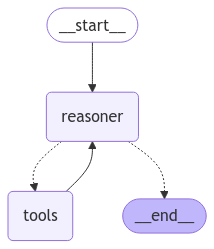

In [16]:
react_graph

### **Invoking:**

In [17]:
messages = [HumanMessage(content="What is 2 times of narendramodi's age?")]
responses = react_graph.invoke({"messages": messages})
responses

{'messages': [HumanMessage(content="What is 2 times of narendramodi's age?", additional_kwargs={}, response_metadata={}, id='291ee996-f8ba-4331-a7e4-06b3b6a4c48c'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7p1g', 'function': {'arguments': '{"query":"narendra modi age"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 88, 'prompt_tokens': 1423, 'total_tokens': 1511, 'completion_time': 0.16, 'prompt_time': 0.045614128, 'queue_time': 0.004000444000000006, 'total_time': 0.205614128}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-99cb9e08-fd35-4a03-bb1a-ff96aad44848-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'narendra modi age'}, 'id': 'call_7p1g', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1423, 'output_tokens': 88, 'total_tokens': 1511}),
  ToolMessage(content="Learn about Narendra Modi

In [18]:
for m in responses['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 times of narendramodi's age?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_7p1g)
 Call ID: call_7p1g
  Args:
    query: narendra modi age
================================= Tool Message =================================
Name: duckduckgo_search

Learn about Narendra Modi, the prime minister of India since 2014 and a leader of the Bharatiya Janata Party. Find out his date of birth, political achievements, controversies, and more. Narendra Modi | Age: 74. Narendra Modi was born on September 17, 1950, and has served as the Prime Minister of India since 2014. Beforehand, he used to hold the role of chief minister of Gujarat in 2001-2014. Modi is best known for his impressive impact on India's economic growth. Learn about the life and achievements of Narendra Modi, the current Prime Minister of India, who was born on September 17,

In [20]:
messages = [HumanMessage(content="What is the result when you add 100 years to the current age of Elon Musk?")]
responses = react_graph.invoke({"messages": messages})

for m in responses['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the result when you add 100 years to the current age of Elon Musk?
================================== Ai Message ==================================
Tool Calls:
  add (call_wn5r)
 Call ID: call_wn5r
  Args:
    a: 100
    b: 51
================================= Tool Message =================================
Name: add

151
================================== Ai Message ==================================

The result when you add 100 years to the current age of Elon Musk is 151.


## **LangGraph Integration 2:**

### **Create or Define Tools:**

In [22]:
# Stock price:

import yfinance as yf

def get_stock_price(ticker: str) -> float:
    """Gets a stock price from Yahoo Finance.

    Args:
        ticker: ticker str
    """
    # """This is a tool for getting the price of a stock when passed a ticker symbol"""
    stock = yf.Ticker(ticker)
    return stock.info['previousClose']

get_stock_price("AAPL")

249.79

In [ ]:
tools = [add, multiply, divide, search, get_stock_price]

### **Bind Tool with LLM:**

In [24]:
llm_with_tools = llm.bind_tools(tools)

### **Create Node: Conditional**

In [23]:
# Node
def reasoner(state):
    query = state["query"]
    messages = state["messages"]
    # System message
    sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs.")
    message = HumanMessage(content=query)
    messages.append(message)
    result = [llm_with_tools.invoke([sys_msg] + messages)]
    return {"messages":result}



### **Define Structure Output Format:**

In [25]:
class GraphState(TypedDict):
    """State of the graph."""
    query: str
    finance: str
    final_answer: str
    # intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]
    messages: Annotated[list[AnyMessage], operator.add]

### **Build Graph:**

In [26]:
# Graph
workflow = StateGraph(GraphState)

# Add Nodes
workflow.add_node("reasoner", reasoner)
workflow.add_node("tools", ToolNode(tools)) # for the tools

# Add Edges
workflow.add_edge(START, "reasoner")

workflow.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)
workflow.add_edge("tools", "reasoner")
react_graph = workflow.compile()

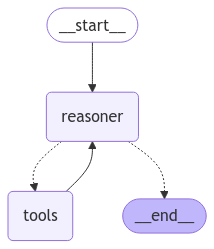

In [27]:
react_graph

### **Start Invoking:**

In [30]:
response = react_graph.invoke({"query": "What is the stock price of Apple add 1000?", "messages": []})

for m in response['messages']:
    m.pretty_print()